In [3]:
!module load CUDA/10.2.89

In [8]:
import prodigy

In [9]:
spacy.__version__
# prodigy.__version__

'1.11.7'

# Predict on all samples after model has been trained

In [12]:
import spacy
import pandas as pd
spacy.prefer_gpu()
# nlp = spacy.load('/home/vs428/project/Moore_models/task_4_textcat_GOLD/model-best/', exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
nlp = spacy.load('/home/vs428/Documents/Moore/followup_model_v3/model-best', exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
#nlp_orig = spacy.load("en_core_web_trf")
#nlp.add_pipe("parser", source=nlp_orig, after="transformer")
#nlp.add_pipe("tagger", source=nlp_orig, after="parser")
#nlp.add_pipe("attribute_ruler", source=nlp_orig, after="tagger")
#nlp.add_pipe("lemmatizer", source=nlp_orig, after="attribute_ruler")
#nlp.add_pipe("ner", source=nlp_orig, after="lemmatizer")

In [13]:
# input_file = 'current cancer flags 6_23_2022.csv'
input_file = '/home/vs428/scratch60/Kevin_backup/prodigy/current cancer flags 6_23_2022.csv'


In [14]:
data_in = pd.read_csv(input_file, index_col=0)

In [15]:
nlp(data_in['value_source_value'].iloc[0]).cats

{'NO_FOLLOWUP': 0.9352397918701172,
 'HARD_FOLLOWUP': 0.03514695540070534,
 'CONDITIONAL_FOLLOWUP': 0.029613260179758072}

In [16]:
# taken from https://stackoverflow.com/a/44764557/1726404
'''
This works by using nlp.pipe and putting our records into tuples. We process it as tuples and get the context
In our work, the context is just the study id. 
We get the entity text, label, start and stop characters for each entity
we convert that to a json string, we then put the [context,json] together into a list
append this list to nlp_out
then turn nlp out into a df with 1 col being study id and the other being the nlp out
Finally we merge the df with our main data df. Now we have a column with the text
'''
import json
nlp_out = []
count = 0
for doc, ctx in nlp.pipe(list(data_in[['value_source_value', 'study_id']].to_records(index=False)),
                                    as_tuples=True, batch_size=50, n_process=1):
    out_ = doc.cats
    nlp_out.append([ctx, json.dumps(out_, indent = 2)])
    print(count)
    count +=1
nlp_df = pd.DataFrame(nlp_out, columns=['study_id', 'NLP_OUT'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [ ]:
nlp_df

In [ ]:
# nlp_df.to_csv('task_4_TEXTCAT_GOLD_nlp_df_v2.csv')

In [ ]:
df = nlp_df

taken from thresholds_task_2_and_4_AND_thresholded_preds as we used this to get the proper columns

In [ ]:
def task_4_pred_scores(x):
    tmp = eval(x['NLP_OUT'])
    pred = max(tmp, key=tmp.get)
    score = tmp[pred]
    # we will return the scores rather than the pred and score
    return pred, score, tmp['CONDITIONAL_FOLLOWUP'], tmp['HARD_FOLLOWUP'], tmp['NO_FOLLOWUP']

In [ ]:
df[['task_4_thresh_pred', 'task_4_top_score','CONDITIONAL_FOLLOWUP_score', 'HARD_FOLLOWUP_score', 'NO_FOLLOWUP_score']] = df.apply(task_4_pred_scores, axis=1, result_type='expand')

In [ ]:
training_ids = pd.read_csv('Task_4_textcat_input.csv', index_col=0)['study_id']

In [ ]:
df['train_set'] = df['study_id'].isin( training_ids)

In [ ]:
df

In [ ]:
# df.to_csv('pipeline_v3_prior_future_cancers 9_14_2022_preds_scores.csv')

# get confusion matrix for task 4 uing the training set/annotations

In [1]:
from collections import Counter, defaultdict
from prodigy.components.db import connect
from prodigy import set_hashes
import pandas as pd
import hashlib

In [6]:
db = connect()
examples = db.get_dataset("ct_images_75_25_500_TASK4")
annotations = []
for idx, eg in enumerate(examples):
    session = eg["_session_id"].split("-")[1] if "_session_id" in eg else "n/a"
    text = hashlib.sha256(eg['text'].strip().encode('utf-8')).hexdigest()
    if 'accept' in eg and len(eg['accept']) > 0:
        tmp = {'text_hash': text, 'text': eg['text'].strip(), 'annotator': session, 'y_true': eg['accept'][0]}
    else:
        print('no answer by annotator {}'.format(session))
        continue
    annotations.append(tmp)
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
df = pd.DataFrame(annotations)

In [8]:
df

,text_hash,text,annotator,y_true
0,42e834d7d803d604bd9d236b3992b8c36a768722a29f23...,CTA CHEST (PE) W IV CONTRAST INDICATION: Sudd...,rat4,NO_FOLLOWUP
1,2c4a11722daae287aa47126a809d7aed149bb43225f195...,Study: CTA of the pulmonary arteries with IV c...,rat4,NO_FOLLOWUP
2,50ef8346815ddb6af2c81df7c484dc46ff20d8e7cb8feb...,CT CHEST ABDOMEN PELVIS W IV CONTRAST CT 2D RE...,rat4,NO_FOLLOWUP
3,7015acd76b4488bbf2d75669c03f3f0147dfdac8bc05fd...,CTA CHEST (PE) W IV CONTRAST INDICATION: Left...,rat4,CONDITIONAL_FOLLOWUP
4,9d3ebd388ca48872654a983128079aacf353c6a10079ff...,Study: CT pulmonary angiogram. HISTORY: Evalu...,rat4,NO_FOLLOWUP
...,...,...,...,...
496,8f2c396e055ccd4817b4289361ab768de69421d1994f06...,CTA CHEST (PE) W IV CONTRAST INDICATION: PE su...,Joec,HARD_FOLLOWUP
497,639f46b3c96ec5ae5c995d11bfa0b1d25aa6636cc982a1...,Study: CTA CHEST W AND/OR WO IV CONTRAST HIST...,Joec,CONDITIONAL_FOLLOWUP
498,ceb9d1971663e08c58daaab21ce75d7c4b072e405c3d90...,CTA of the chest abdomen without and with IV c...,Joec,CONDITIONAL_FOLLOWUP
499,9814a67162d653385ef889b5fd1b01a2bd98effecba64d...,CTA CHEST (PE) W IV CONTRAST INDICATION: hemo...,Joec,HARD_FOLLOWUP


# This is to find which annotators match vs dont match

In [ ]:
rat4 = df[df['annotator'] == 'rat4']
rdenkewicz = df[df['annotator'] == 'rdenkewicz']
rat4_rdenkewicz =  pd.merge(rat4, rdenkewicz, on=['text_hash'])
rat4_rdenkewicz['annotator_matches'] = rat4_rdenkewicz.apply(lambda x: x['y_true_x'] == x['y_true_y'], axis=1)
rat4_rdenkewicz[rat4_rdenkewicz['annotator_matches'] == False]

In [ ]:
import spacy
import pandas as pd
spacy.prefer_gpu()
nlp = spacy.load('/home/kl533/prodigy/task_4_textcat_SILVER/model-best/', exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
#nlp_orig = spacy.load("en_core_web_trf")

In [ ]:
import json
nlp_out = []
count = 0
for doc, ctx in nlp.pipe(list(df[['text', 'text_hash']].drop_duplicates(subset='text_hash').to_records(index=False)),
                                    as_tuples=True, batch_size=50, n_process=1):
    out_ = doc.cats
    nlp_out.append([ctx, max(out_, key=out_.get)])
    print(count)
    count +=1
nlp_df = pd.DataFrame(nlp_out, columns=['text_hash', 'y_pred'])

In [ ]:
res = pd.merge(df, nlp_df, on='text_hash')

In [ ]:
res

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(res['y_true'])

In [ ]:
le.classes_

In [ ]:
res['y_true'] = le.transform(res['y_true'])
res['y_pred'] = le.transform(res['y_pred'])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
res_rat4 = res[res['annotator'] == 'rat4']
res_rdenkewicz = res[res['annotator'] == 'rdenkewicz']
res_rdenkewicz = res_rdenkewicz.drop_duplicates('text_hash')

# RAT4

In [ ]:
print(classification_report(res_rat4['y_true'], res_rat4['y_pred'], target_names=le.classes_))

In [ ]:
cm = confusion_matrix(res_rat4['y_true'], res_rat4['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=le.classes_)
disp.plot(xticks_rotation='vertical')

# rdenkewicz

In [ ]:
print(classification_report(res_rdenkewicz['y_true'], res_rdenkewicz['y_pred'], target_names=le.classes_))

In [ ]:
cm = confusion_matrix(res_rdenkewicz['y_true'], res_rdenkewicz['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=le.classes_)
disp.plot(xticks_rotation='vertical')

# Get confusion matrix for the samples from the Adjudicated DB

In [18]:
from collections import Counter, defaultdict
from prodigy.components.db import connect
from prodigy import set_hashes
import pandas as pd
import hashlib

In [19]:
db = connect()
# examples = db.get_dataset("ct_images_75_25_500_TASK4_GOLD")
# examples = db.get_dataset("moore_followup_GOLD")
examples = db.get_dataset("followup_pipeline_v2")

annotations = []
for idx, eg in enumerate(examples):
    session = eg["_session_id"].split("-")[1] if "_session_id" in eg else "n/a"
    text = hashlib.sha256(eg['text'].strip().encode('utf-8')).hexdigest()
    if 'accept' in eg and len(eg['accept']) > 0:
        tmp = {'text_hash': text, 'text': eg['text'].strip(), 'annotator': session, 'y_true': eg['accept'][0]}
    else:
        print('no answer by annotator {}'.format(session))
        continue
    annotations.append(tmp)
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
df = pd.DataFrame(annotations)

In [21]:
df

,text_hash,text,annotator,y_true
0,42e834d7d803d604bd9d236b3992b8c36a768722a29f23...,CTA CHEST (PE) W IV CONTRAST INDICATION: Sudd...,rat4,NO_FOLLOWUP
1,2c4a11722daae287aa47126a809d7aed149bb43225f195...,Study: CTA of the pulmonary arteries with IV c...,rat4,NO_FOLLOWUP
2,50ef8346815ddb6af2c81df7c484dc46ff20d8e7cb8feb...,CT CHEST ABDOMEN PELVIS W IV CONTRAST CT 2D RE...,rat4,NO_FOLLOWUP
3,25dc255dccb5118a5784dba735f8ffdc0fc883cee820f3...,. Likely subacute fracture of spinous process ...,rat4,CONDITIONAL_FOLLOWUP
4,9d3ebd388ca48872654a983128079aacf353c6a10079ff...,Study: CT pulmonary angiogram. HISTORY: Evalu...,rat4,NO_FOLLOWUP
...,...,...,...,...
919,58ee6cb8c8adafe63c67c9777b1cdb470990866598556c...,CTA CHEST ABDOMEN PELVIS W AND/OR WO IV CONTRA...,rdenkewicz,NO_FOLLOWUP
920,c95a87541537f2c968cffbc06d1286aa255f93e90e36f8...,STUDY: CTA CHEST (PE) W IV CONTRAST INDICATIO...,rdenkewicz,CONDITIONAL_FOLLOWUP
921,c9add58d185a383107cea4e05d9be56e0c4f42cbae48d6...,CT CHEST WO IV CONTRAST Date: 7/12/2021 6:17 P...,rdenkewicz,CONDITIONAL_FOLLOWUP
922,7001c92f965734a790505653bd1044146779a6190563fd...,CTA CHEST (PE) W IV CONTRAST INDICATION: Pulmo...,rdenkewicz,HARD_FOLLOWUP


# This is to find which annotators match vs dont match

In [22]:
rat4 = df[df['annotator'] == 'rat4']
rdenkewicz = df[df['annotator'] == 'rdenkewicz']
rat4_rdenkewicz =  pd.merge(rat4, rdenkewicz, on=['text_hash'])
rat4_rdenkewicz['annotator_matches'] = rat4_rdenkewicz.apply(lambda x: x['y_true_x'] == x['y_true_y'], axis=1)
rat4_rdenkewicz[rat4_rdenkewicz['annotator_matches'] == False]

,text_hash,text_x,annotator_x,y_true_x,text_y,annotator_y,y_true_y,annotator_matches


In [23]:
import spacy
import pandas as pd
spacy.prefer_gpu()
# nlp = spacy.load('/home/vs428/project/Moore_models/task_4_textcat_GOLD/model-best/', exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
nlp = spacy.load('/home/vs428/Documents/Moore/followup_model_v3/model-best', exclude="tagger,parser,attribute_ruler,lemmatizer,ner")

#nlp_orig = spacy.load("en_core_web_trf")

In [24]:
import json
nlp_out = []
count = 0
for doc, ctx in nlp.pipe(list(df[['text', 'text_hash']].drop_duplicates(subset='text_hash').to_records(index=False)),
                                    as_tuples=True, batch_size=50, n_process=1):
    out_ = doc.cats
    nlp_out.append([ctx, max(out_, key=out_.get)])
    print(count)
    count +=1
nlp_df = pd.DataFrame(nlp_out, columns=['text_hash', 'y_pred'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
res = pd.merge(df, nlp_df, on='text_hash')

In [26]:
res

,text_hash,text,annotator,y_true,y_pred
0,42e834d7d803d604bd9d236b3992b8c36a768722a29f23...,CTA CHEST (PE) W IV CONTRAST INDICATION: Sudd...,rat4,NO_FOLLOWUP,NO_FOLLOWUP
1,2c4a11722daae287aa47126a809d7aed149bb43225f195...,Study: CTA of the pulmonary arteries with IV c...,rat4,NO_FOLLOWUP,NO_FOLLOWUP
2,50ef8346815ddb6af2c81df7c484dc46ff20d8e7cb8feb...,CT CHEST ABDOMEN PELVIS W IV CONTRAST CT 2D RE...,rat4,NO_FOLLOWUP,NO_FOLLOWUP
3,25dc255dccb5118a5784dba735f8ffdc0fc883cee820f3...,. Likely subacute fracture of spinous process ...,rat4,CONDITIONAL_FOLLOWUP,CONDITIONAL_FOLLOWUP
4,9d3ebd388ca48872654a983128079aacf353c6a10079ff...,Study: CT pulmonary angiogram. HISTORY: Evalu...,rat4,NO_FOLLOWUP,NO_FOLLOWUP
...,...,...,...,...,...
919,58ee6cb8c8adafe63c67c9777b1cdb470990866598556c...,CTA CHEST ABDOMEN PELVIS W AND/OR WO IV CONTRA...,rdenkewicz,NO_FOLLOWUP,NO_FOLLOWUP
920,c95a87541537f2c968cffbc06d1286aa255f93e90e36f8...,STUDY: CTA CHEST (PE) W IV CONTRAST INDICATIO...,rdenkewicz,CONDITIONAL_FOLLOWUP,CONDITIONAL_FOLLOWUP
921,c9add58d185a383107cea4e05d9be56e0c4f42cbae48d6...,CT CHEST WO IV CONTRAST Date: 7/12/2021 6:17 P...,rdenkewicz,CONDITIONAL_FOLLOWUP,CONDITIONAL_FOLLOWUP
922,7001c92f965734a790505653bd1044146779a6190563fd...,CTA CHEST (PE) W IV CONTRAST INDICATION: Pulmo...,rdenkewicz,HARD_FOLLOWUP,HARD_FOLLOWUP


In [27]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(res['y_true'])

LabelEncoder()

In [28]:
le.classes_

array(['CONDITIONAL_FOLLOWUP', 'HARD_FOLLOWUP', 'NO_FOLLOWUP'],
      dtype=object)

In [29]:
res['y_true'] = le.transform(res['y_true'])
res['y_pred'] = le.transform(res['y_pred'])

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

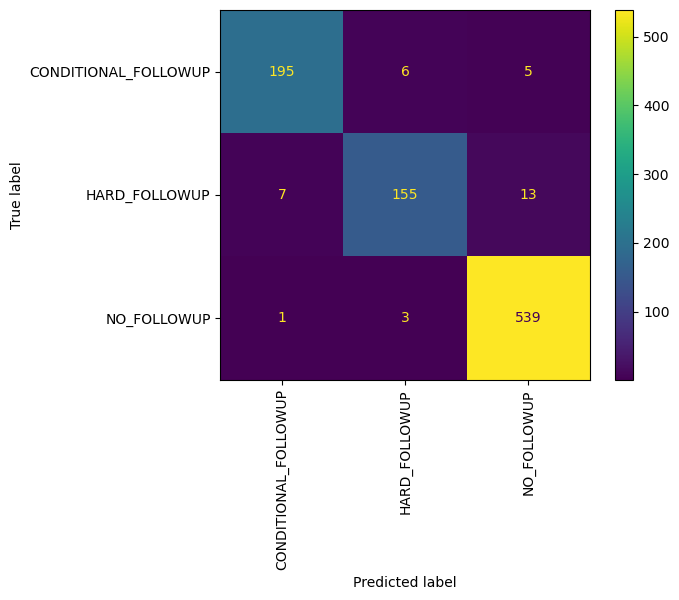

In [31]:
cm = confusion_matrix(res['y_true'], res['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=le.classes_)
disp.plot(xticks_rotation='vertical')

In [32]:
print(classification_report(res['y_true'], res['y_pred'], target_names=le.classes_))

                      precision    recall  f1-score   support

CONDITIONAL_FOLLOWUP       0.96      0.95      0.95       206
       HARD_FOLLOWUP       0.95      0.89      0.91       175
         NO_FOLLOWUP       0.97      0.99      0.98       543

            accuracy                           0.96       924
           macro avg       0.96      0.94      0.95       924
        weighted avg       0.96      0.96      0.96       924



# Other!!!


In [31]:
import spacy
import pandas as pd
spacy.prefer_gpu()
nlp = spacy.load('/home/vs428/Documents/Moore/followup_model_v2/model-best', exclude="tagger,parser,attribute_ruler,lemmatizer,ner")
#nlp_orig = spacy.load("en_core_web_trf")

In [32]:
import json
nlp_out = []
count = 0
for doc, ctx in nlp.pipe(list(df[['text', 'text_hash']].drop_duplicates(subset='text_hash').to_records(index=False)),
                                    as_tuples=True, batch_size=50, n_process=1):
    out_ = doc.cats
    nlp_out.append([ctx, max(out_, key=out_.get)])
    print(count)
    count +=1
nlp_df = pd.DataFrame(nlp_out, columns=['text_hash', 'y_pred'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
res = pd.merge(df, nlp_df, on='text_hash')

In [34]:
res

,text_hash,text,annotator,y_true,y_pred
0,42e834d7d803d604bd9d236b3992b8c36a768722a29f23...,CTA CHEST (PE) W IV CONTRAST INDICATION: Sudd...,rat4,NO_FOLLOWUP,NO_FOLLOWUP
1,2c4a11722daae287aa47126a809d7aed149bb43225f195...,Study: CTA of the pulmonary arteries with IV c...,rat4,NO_FOLLOWUP,NO_FOLLOWUP
2,50ef8346815ddb6af2c81df7c484dc46ff20d8e7cb8feb...,CT CHEST ABDOMEN PELVIS W IV CONTRAST CT 2D RE...,rat4,NO_FOLLOWUP,NO_FOLLOWUP
3,7015acd76b4488bbf2d75669c03f3f0147dfdac8bc05fd...,CTA CHEST (PE) W IV CONTRAST INDICATION: Left...,rat4,CONDITIONAL_FOLLOWUP,CONDITIONAL_FOLLOWUP
4,9d3ebd388ca48872654a983128079aacf353c6a10079ff...,Study: CT pulmonary angiogram. HISTORY: Evalu...,rat4,NO_FOLLOWUP,NO_FOLLOWUP
...,...,...,...,...,...
496,8f2c396e055ccd4817b4289361ab768de69421d1994f06...,CTA CHEST (PE) W IV CONTRAST INDICATION: PE su...,Joec,HARD_FOLLOWUP,HARD_FOLLOWUP
497,639f46b3c96ec5ae5c995d11bfa0b1d25aa6636cc982a1...,Study: CTA CHEST W AND/OR WO IV CONTRAST HIST...,Joec,CONDITIONAL_FOLLOWUP,NO_FOLLOWUP
498,ceb9d1971663e08c58daaab21ce75d7c4b072e405c3d90...,CTA of the chest abdomen without and with IV c...,Joec,CONDITIONAL_FOLLOWUP,HARD_FOLLOWUP
499,9814a67162d653385ef889b5fd1b01a2bd98effecba64d...,CTA CHEST (PE) W IV CONTRAST INDICATION: hemo...,Joec,HARD_FOLLOWUP,HARD_FOLLOWUP


In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(res['y_true'])

LabelEncoder()

In [36]:
le.classes_

array(['CONDITIONAL_FOLLOWUP', 'HARD_FOLLOWUP', 'NO_FOLLOWUP'],
      dtype=object)

In [37]:
res['y_true'] = le.transform(res['y_true'])
res['y_pred'] = le.transform(res['y_pred'])

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

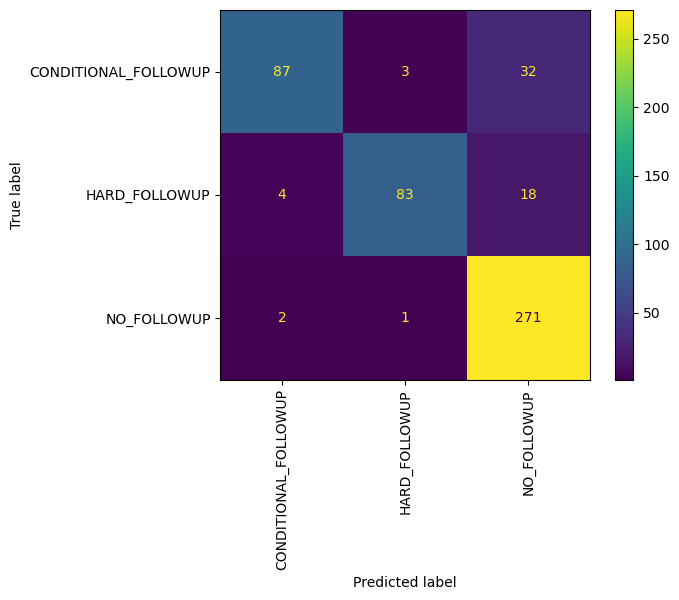

In [59]:

cm = confusion_matrix(res['y_true'], res['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=le.classes_)
# disp.ax_.set_title("TEST")
disp.plot(xticks_rotation='vertical')

In [40]:
print(classification_report(res['y_true'], res['y_pred'], target_names=le.classes_))

                      precision    recall  f1-score   support

CONDITIONAL_FOLLOWUP       0.94      0.71      0.81       122
       HARD_FOLLOWUP       0.95      0.79      0.86       105
         NO_FOLLOWUP       0.84      0.99      0.91       274

            accuracy                           0.88       501
           macro avg       0.91      0.83      0.86       501
        weighted avg       0.89      0.88      0.88       501

